# Load data into Spark DataFrame

In [1]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0
      /_/

Using Python version 3.5.5 (default, Mar 12 2018 16:25:05)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
from pyspark.context import SparkContext
from pyspark.sql import HiveContext
sqlContext = HiveContext(sc)

import pyspark.sql.functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('../data/event_ds.csv')

In [5]:
# create new or overwrite original field with withColumn
df = df.withColumn('date', F.col('date').cast('date'))
# df.show()

In [6]:
sqlContext.registerDataFrameAsTable(df, "event")
sqlContext.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |    event|       true|
+--------+---------+-----------+



In [7]:
sqlContext.sql("select * from event limit 10").show()

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168542959|    P| 6124109|2017-03-30|
|168548032|    P|  896579|2017-03-30|
|168550948|    P|  277286|2017-03-30|
|168550949|    P|  360750|2017-03-30|
|168550716|    P| 1873326|2017-03-30|
|168547123|    P|       0|2017-03-30|
|168551120|    P|22858485|2017-03-30|
|168550329|    P| 3514083|2017-03-30|
|168548032|    P| 6684886|2017-03-30|
|168551589|    P| 1179220|2017-03-30|
+---------+-----+--------+----------+



### Some exploration

In [8]:
## count distinct user id
sqlContext.sql("select count(distinct uid) from event").show()

+-------------------+
|count(DISTINCT uid)|
+-------------------+
|              60003|
+-------------------+



In [9]:
# group by aggregation
# df.groupBy('event').count().show()
sqlContext.sql('''
    select event, count(1) as COUNT, min(uid), max(uid) 
    from event
    group by event
    ''').show()

+-----+--------+---------+--------+
|event|   COUNT| min(uid)|max(uid)|
+-----+--------+---------+--------+
|    D|  647688|100202712|99800656|
|    S|  783461|100202712|99800656|
|    P|10961522|100202712|99800656|
+-----+--------+---------+--------+



In [10]:
sqlContext.sql('''
    select date, event, count(*) as count
    from event
    where date >= '2017-04-29'
    group by 1,2
    order by 1,2
    ''').show()  

+----------+-----+------+
|      date|event| count|
+----------+-----+------+
|2017-04-29|    D|  8778|
|2017-04-29|    P|209596|
|2017-04-29|    S| 14325|
|2017-04-30|    D|  8125|
|2017-04-30|    P|205213|
|2017-04-30|    S| 13407|
|2017-05-01|    D| 13509|
|2017-05-01|    P|203396|
|2017-05-01|    S| 13272|
|2017-05-02|    D|  6854|
|2017-05-02|    P|177877|
|2017-05-02|    S| 11644|
|2017-05-03|    D|  5302|
|2017-05-03|    P|181454|
|2017-05-03|    S| 10922|
|2017-05-04|    D|  8412|
|2017-05-04|    P|181906|
|2017-05-04|    S| 10882|
|2017-05-05|    D|  6978|
|2017-05-05|    P|179756|
+----------+-----+------+
only showing top 20 rows



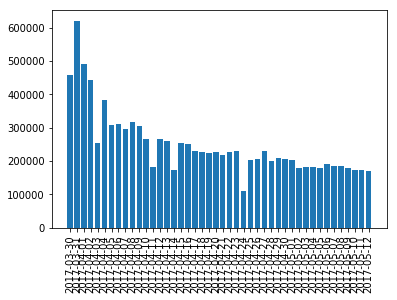

In [11]:
# date_count = df.groupBy('date').count().orderBy('date').toPandas()
date_count = sqlContext.sql('''
    select date, event, count(*) as count
    from event
    group by 1,2
    order by 1,2
    ''').toPandas()

plt.bar(date_count['date'].astype(str), date_count['count'])
plt.xticks(rotation='vertical')
plt.tight_layout;

# Label definition

In [12]:
# import datetime
# from dateutil import parser

# label_window_size = 14
# label_window_end_date = parser.parse('2017-05-12').date()
# label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
# print('label window:', label_window_start_date,'~', 
#       label_window_end_date,'days:', label_window_size)

# feature_window_size = 30
# feature_window_end_date = label_window_start_date - datetime.timedelta(1)
# feature_window_start_date = feature_window_end_date - datetime.timedelta(feature_window_size - 1)
# print('feature window:', feature_window_start_date,'~', 
#       feature_window_end_date,'days:', feature_window_size)

In [13]:
## feature window: 2017-03-30 ~ 2017-04-28 days: 30
## all the uid that we will use for the model
sqlContext.sql('''
CREATE TEMPORARY VIEW df_model_uid AS
    SELECT DISTINCT uid
    FROM event
    WHERE date >= '2017-03-30' AND date <= '2017-04-28'
    ''')

sqlContext.sql('SELECT COUNT(*) FROM df_model_uid').show()

+--------+
|count(1)|
+--------+
|   58693|
+--------+



In [14]:
## label window: 2017-04-29 ~ 2017-05-12 days: 14
## active uid in label window
sqlContext.sql('''
CREATE TEMPORARY VIEW df_active_uid AS
    SELECT DISTINCT uid
    FROM event
    WHERE date >= '2017-04-29' and date <= '2017-05-12'
    ''')

sqlContext.sql('SELECT COUNT(*) FROM df_active_uid').show()

+--------+
|count(1)|
+--------+
|   23531|
+--------+



In [15]:
## left join and return the uid and label for the model
sqlContext.sql('''
CREATE TEMPORARY VIEW df_label AS
    SELECT df_model_uid.uid,
        CASE
            WHEN df_active_uid.uid > 0 THEN 0
            ELSE 1
        END AS churn
    FROM df_model_uid
    LEFT JOIN df_active_uid
        ON df_model_uid.uid = df_active_uid.uid
    ''')

sqlContext.sql('SELECT * FROM df_label LIMIT 10').show()

+---------+-----+
|      uid|churn|
+---------+-----+
|128106175|    1|
|160554394|    0|
|166397219|    1|
|167574952|    1|
|167576066|    0|
|167577418|    1|
|167582447|    1|
|167596703|    1|
|167606193|    0|
|167612678|    1|
+---------+-----+



In [16]:
## check if the labels are almost balanced
sqlContext.sql('''
    SELECT churn, COUNT(*)
    FROM df_label
    GROUP BY churn
    ''').show()

+-----+--------+
|churn|count(1)|
+-----+--------+
|    1|   36472|
|    0|   22221|
+-----+--------+



# Feature generation

In [17]:
# event_data in feature_window
sqlContext.sql('''
CREATE TEMPORARY VIEW df_feature_window AS
    SELECT *
    FROM event
    WHERE date >= '2017-03-30' AND date <= '2017-04-28'
    ''')

sqlContext.sql('SELECT COUNT(*) FROM df_feature_window').show()

+--------+
|count(1)|
+--------+
| 9534079|
+--------+



### Frequency features

In [18]:
## defined as count of events happend in last X days
sqlContext.sql('''
CREATE TEMPORARY VIEW frequency_features AS
    SELECT uid, 
        SUM(CASE WHEN event = 'D' AND date >= '2017-04-28' THEN 1 ELSE 0 END) AS freq_D_last_1,
        SUM(CASE WHEN event = 'S' AND date >= '2017-04-28' THEN 1 ELSE 0 END) AS freq_S_last_1,
        SUM(CASE WHEN event = 'P' AND date >= '2017-04-28' THEN 1 ELSE 0 END) AS freq_P_last_1,
        SUM(CASE WHEN event = 'D' AND date >= '2017-04-26' THEN 1 ELSE 0 END) AS freq_D_last_3,
        SUM(CASE WHEN event = 'S' AND date >= '2017-04-26' THEN 1 ELSE 0 END) AS freq_S_last_3,
        SUM(CASE WHEN event = 'P' AND date >= '2017-04-26' THEN 1 ELSE 0 END) AS freq_P_last_3,
        SUM(CASE WHEN event = 'D' AND date >= '2017-04-22' THEN 1 ELSE 0 END) AS freq_D_last_7,
        SUM(CASE WHEN event = 'S' AND date >= '2017-04-22' THEN 1 ELSE 0 END) AS freq_S_last_7,
        SUM(CASE WHEN event = 'P' AND date >= '2017-04-22' THEN 1 ELSE 0 END) AS freq_P_last_7,
        SUM(CASE WHEN event = 'D' AND date >= '2017-04-15' THEN 1 ELSE 0 END) AS freq_D_last_14,
        SUM(CASE WHEN event = 'S' AND date >= '2017-04-15' THEN 1 ELSE 0 END) AS freq_S_last_14,
        SUM(CASE WHEN event = 'P' AND date >= '2017-04-15' THEN 1 ELSE 0 END) AS freq_P_last_14,
        SUM(CASE WHEN event = 'D' THEN 1 ELSE 0 END) AS freq_D_last_30,
        SUM(CASE WHEN event = 'S' THEN 1 ELSE 0 END) AS freq_S_last_30,
        SUM(CASE WHEN event = 'P' THEN 1 ELSE 0 END) AS freq_P_last_30
    FROM df_feature_window
    GROUP BY uid
    ''')

sqlContext.sql('SELECT * FROM frequency_features').show(2)

+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+
|      uid|freq_D_last_1|freq_S_last_1|freq_P_last_1|freq_D_last_3|freq_S_last_3|freq_P_last_3|freq_D_last_7|freq_S_last_7|freq_P_last_7|freq_D_last_14|freq_S_last_14|freq_P_last_14|freq_D_last_30|freq_S_last_30|freq_P_last_30|
+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+
| 81114900|            0|            0|            0|            0|            0|            0|            0|            0|            0|             0|             0|             0|             0|             0|            14|
|168555996|            0|            0|            0|            0|            0|       

### Recency features

In [19]:
## defined as days from last event
## can generate one feature for each type of event
sqlContext.sql('''
CREATE TEMPORARY VIEW recency_features AS
    SELECT D.uid, D.recency_D, S.recency_S, P.recency_P
    FROM
        (SELECT uid, datediff(to_date('2017-04-28'), MAX(date)) AS recency_D
        FROM df_feature_window
        WHERE event = 'D'
        GROUP BY uid) AS D
    JOIN
        (SELECT uid, datediff(to_date('2017-04-28'), MAX(date)) AS recency_S
        FROM df_feature_window
        WHERE event = 'S'
        GROUP BY uid) AS S
    ON D.uid = S.uid
    JOIN
        (SELECT uid, datediff(to_date('2017-04-28'), MAX(date)) AS recency_P
        FROM df_feature_window
        WHERE event = 'P'
        GROUP BY uid) AS P
    ON D.uid = P.uid
    ''')

sqlContext.sql('SELECT * FROM recency_features').show(10)

+---------+---------+---------+---------+
|      uid|recency_D|recency_S|recency_P|
+---------+---------+---------+---------+
|167606193|       11|       11|        0|
|167621306|        8|        3|        1|
|167659082|       19|        9|        0|
|167667113|        5|        3|        1|
|167677091|        4|        2|        0|
|167708557|       21|       16|       12|
|167719927|       28|       28|       27|
|167756744|        3|        1|        0|
|167764301|       15|       11|       11|
|167772654|        0|        0|        0|
+---------+---------+---------+---------+
only showing top 10 rows



### Profile features

In [20]:
df_play = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('../data/play_ds.csv')
df_play = df_play.withColumn('date', F.col('date').cast('date'))

In [21]:
sqlContext.registerDataFrameAsTable(df_play, "play")
sqlContext.sql("show tables").show()

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
|        |     df_active_uid|       true|
|        | df_feature_window|       true|
|        |          df_label|       true|
|        |      df_model_uid|       true|
|        |             event|       true|
|        |frequency_features|       true|
|        |              play|       true|
|        |  recency_features|       true|
+--------+------------------+-----------+



In [22]:
## extract the log data in feature window
sqlContext.sql('''
CREATE TEMPORARY VIEW df_play_feature_window AS
    SELECT * FROM play
    WHERE date >= '2017-03-30' AND date <= '2017-04-28'
    ''')

sqlContext.sql('SELECT * FROM df_play_feature_window').show(10)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168542959|    ar| 6124109|2017-03-30|      335|        336|
|168548032|    ip|  896579|2017-03-30|        8|        184|
|168550948|    ar|  277286|2017-03-30|      254|        254|
|168550949|    ar|  360750|2017-03-30|      249|        249|
|168550716|    ar| 1873326|2017-03-30|       24|        234|
|168547123|    ar|       0|2017-03-30|        9|        243|
|168551120|    ar|22858485|2017-03-30|      119|        233|
|168550329|    ar| 3514083|2017-03-30|      274|        273|
|168548032|    ip| 6684886|2017-03-30|        6|        320|
|168551589|    ar| 1179220|2017-03-30|      217|        231|
+---------+------+--------+----------+---------+-----------+
only showing top 10 rows



In [23]:
# check if one user has two devices
sqlContext.sql('''
SELECT COUNT(DISTINCT uid, device), COUNT(DISTINCT uid) 
FROM df_play_feature_window
''').show()

+---------------------------+-------------------+
|count(DISTINCT uid, device)|count(DISTINCT uid)|
+---------------------------+-------------------+
|                      58537|              58522|
+---------------------------+-------------------+



In [24]:
# count group by device
sqlContext.sql('''
SELECT device, count(1) as count, round(count(1)/58537,2) as percentage
FROM(
    SELECT distinct(uid), device
    FROM df_play_feature_window)
GROUP BY device
''').show()

+------+-----+----------+
|device|count|percentage|
+------+-----+----------+
|    ar|51058|      0.87|
|    wp|    1|       0.0|
|    ip| 7478|      0.13|
+------+-----+----------+



In [25]:
## device_type = 1 (if iphone), device_type = 0 (if not iphone)
sqlContext.sql('''
CREATE TEMPORARY VIEW profile_features AS
    SELECT uid, CASE WHEN device = 'ip' THEN 1 ELSE 0 END AS device_type
    FROM df_play_feature_window
    ''')

sqlContext.sql('SELECT device_type, count(1) FROM profile_features GROUP BY device_type').show()

+-----------+--------+
|device_type|count(1)|
+-----------+--------+
|          1| 1387228|
|          0| 6980849|
+-----------+--------+



### Play time features

In [26]:
# generate counts of songs play 80% of their song length (using play_ds data) for different time window
# using play data (need to clean play time and song length first, play time may be negative in data)

sqlContext.sql('''
CREATE TEMPORARY VIEW playtime_features AS
    SELECT uid, 
        SUM(CASE WHEN date >= '2017-04-28' THEN 1 ELSE 0 END) AS freq_P_80pct_last_1,
        SUM(CASE WHEN date >= '2017-04-26' THEN 1 ELSE 0 END) AS freq_P_80pct_last_3,
        SUM(CASE WHEN date >= '2017-04-22' THEN 1 ELSE 0 END) AS freq_P_80pct_last_7,
        SUM(CASE WHEN date >= '2017-04-15' THEN 1 ELSE 0 END) AS freq_P_80pct_last_14,
        SUM(CASE WHEN date >= '2017-03-30' THEN 1 ELSE 0 END) AS freq_P_80pct_last_30
    FROM df_play_feature_window
    WHERE play_time > 0 AND play_time >= 0.8*song_length
    GROUP BY uid
    ''')

sqlContext.sql('SELECT * FROM playtime_features').show(10)

+---------+-------------------+-------------------+-------------------+--------------------+--------------------+
|      uid|freq_P_80pct_last_1|freq_P_80pct_last_3|freq_P_80pct_last_7|freq_P_80pct_last_14|freq_P_80pct_last_30|
+---------+-------------------+-------------------+-------------------+--------------------+--------------------+
| 81114900|                  0|                  0|                  0|                   0|                   8|
|168576728|                  0|                  0|                  0|                   0|                   4|
|168580603|                  0|                  0|                  0|                   0|                  38|
|168618438|                  0|                  0|                  0|                   0|                  46|
|168587465|                  0|                  0|                 10|                  19|                  84|
|168642448|                  0|                  0|                  0|                 

# Join all tables and form training data

In [27]:
sqlContext.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|        |       df_active_uid|       true|
|        |   df_feature_window|       true|
|        |            df_label|       true|
|        |        df_model_uid|       true|
|        |df_play_feature_w...|       true|
|        |               event|       true|
|        |  frequency_features|       true|
|        |                play|       true|
|        |   playtime_features|       true|
|        |    profile_features|       true|
|        |    recency_features|       true|
+--------+--------------------+-----------+



In [28]:
df_model_final = sqlContext.sql('''
  SELECT freq.*, recency_D, recency_S, recency_P,
         freq_P_80pct_last_1, freq_P_80pct_last_3, freq_P_80pct_last_7,
         freq_P_80pct_last_14, freq_P_80pct_last_30, device_type, churn
    FROM frequency_features AS freq
    JOIN recency_features AS recency
        ON freq.uid = recency.uid
    JOIN playtime_features AS playtime    
        ON freq.uid = playtime.uid
    JOIN profile_features AS profile
        ON freq.uid = profile.uid
    JOIN df_label AS label
        ON freq.uid = label.uid
    ''')

df_model_final.show(10)

+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+---------+---------+---------+-------------------+-------------------+-------------------+--------------------+--------------------+-----------+-----+
|      uid|freq_D_last_1|freq_S_last_1|freq_P_last_1|freq_D_last_3|freq_S_last_3|freq_P_last_3|freq_D_last_7|freq_S_last_7|freq_P_last_7|freq_D_last_14|freq_S_last_14|freq_P_last_14|freq_D_last_30|freq_S_last_30|freq_P_last_30|recency_D|recency_S|recency_P|freq_P_80pct_last_1|freq_P_80pct_last_3|freq_P_80pct_last_7|freq_P_80pct_last_14|freq_P_80pct_last_30|device_type|churn|
+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+---------+-------

In [30]:
df_model_final.toPandas().to_csv('../data/df_model_final.csv',index=False)